This is the notebook related to MSA data analysis. To run this, please uncomment all the cells an press "Run all" button.

In [1]:
# Set the path and input parameters
import os
directory = os.getcwd() # the main directory of the project

# The credentials for the remote cluster
name = 'alina'
server = 'ecate'

In [2]:
# Import the libraries and functions
from functions import *

## 1. Overview

In [3]:
# Set the maximum width of the columns
pd.set_option('display.max_colwidth', 20)

In [4]:
# Load a dataframe of the disordered regions
disordered_df = pd.read_csv('disordered_df.csv')
curated_disprot_df = pd.read_csv('curated_disprot.csv')
print('The number of rows with the disordered regions: {}'.format(len(disordered_df)))
disordered_df.head()

The number of rows with the disordered regions: 7393


,query_id,subject_id,query_len,hsp_len,query_seq,subject_seq,query_start,query_end,subject_start,subject_end,eval,bit_score,count
0,Q9H832,A0A6J2FM24,354,356,MAESPTEEAATA--GA...,MAESPTEEAATATAGA...,1,354,1,354,0.0,1851.0,200
1,Q9H832,A0A3Q7W6Y2,354,356,MAESPTEEAATA--GA...,MAESPTEEAATATAGA...,1,354,1,354,0.0,1851.0,200
2,Q9H832,A0A2U3VK69,354,356,MAESPTEEAATA--GA...,MAESPTEEAATATAGA...,1,354,1,354,0.0,1851.0,200
3,Q9H832,A0A2Y9JVH5,354,358,MAESPTEEAATA----...,MAESPTEEAATATATA...,1,354,1,356,0.0,1854.0,200
4,Q9H832,A0A8C7ALE4,354,358,MAESPTEEAATA----...,MAESPTEEAATATATA...,1,354,1,356,0.0,1854.0,200


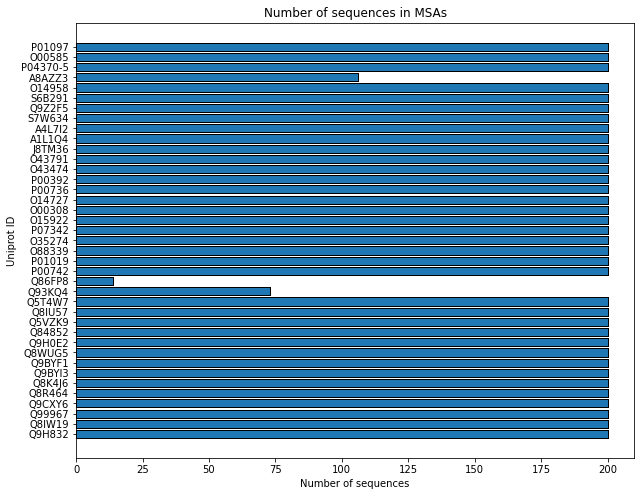

In [13]:
# Plot the number of sequences in each MSA
figure(figsize=(10, 8))
plt.barh(disordered_df['query_id'], disordered_df['count'], edgecolor='black')
plt.xlabel('Number of sequences')
plt.ylabel('Uniprot ID')
plt.title('Number of sequences in MSAs')
plt.show()

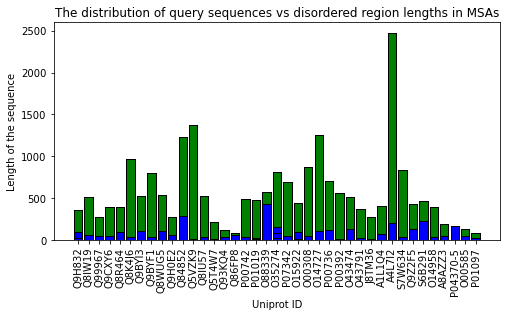

In [11]:
# Select only the information from the disordered dataframe
cur_filt = curated_disprot_df[curated_disprot_df['acc'].isin(disordered_df['query_id'])]

# Plot the length of sequences and the disordered regions of the MSAs
figure(figsize=(8, 4))
plt.bar(disordered_df['query_id'], disordered_df['query_len'], color='green', edgecolor='black')
plt.bar(cur_filt['acc'], cur_filt['length'], color='blue', edgecolor='black')
plt.tick_params(axis='x', labelrotation=90)
plt.xlabel('Uniprot ID')
plt.ylabel('Length of the sequence')
plt.title('The distribution of query sequences vs disordered region lengths in MSAs')
plt.show()

## 2. Multiple Sequence Alignment

Within this framework, we will compare the MSA results obtained directly from the BLAST output with those generated from the ClustalOmega service.

### Analysis of redundancy

For this step we use the input files for ClustalOmega alignment. The goal is to keep only non-redundant regions. We set the threshold for redundancy of 90%. The program implementing the task is called `cd-hit`.

Next, we will be working with the newly generated file. It will be uploaded to ebi website, where we will select Pearson/FASTA as the output format. Once we have downloaded the aligned sequences, we can analyze the alignment using Jalview.

In [16]:
# Set the path for the clusters files
# blast_clstr_path = '{}/results/alignments/output_files/blast/non-redundant'.format(directory)
clustal_clstr_path = '{}/results/alignments/output_files/clustal/non-redundant'.format(directory)
# create_directory(blast_clstr_path)
create_directory(clustal_clstr_path)

Directory /Users/alina/HMM/results/alignments/output_files/clustal/non-redundant already exists.


In [9]:
# Plot dendrograms for MSAs
def plot_dendrograms(clstr_path, ali):
    for cluster_filename in os.listdir(clstr_path):
        if cluster_filename.endswith('.clstr'):
            cluster_path = os.path.join(clstr_path, cluster_filename)

            cluster_data = []
            with open(cluster_path, 'r') as file:
                for line in file:
                    if line.startswith('>Cluster'):
                        continue
                    parts = line.strip().split('\t')
                    percentage_matches = re.findall(r'\d+\.\d+', parts[-1])
                    if percentage_matches:
                        percentage = float(percentage_matches[0])
                        cluster_data.append(percentage)

            # Check if there are at least two observations
            if len(cluster_data) < 2:
                continue

            # Convert the data into a matrix
            matrix_data = np.array(cluster_data).reshape(len(cluster_data), 1)

            # Create linkage matrix using the data and hierarchical clustering
            Z = linkage(matrix_data, method='average')

            prot = cluster_path.split('_')[1].split('/')[3]

            # Plot the dendrogram
            plt.figure(figsize=(10, 6))
            dendrogram(Z, labels=np.arange(len(cluster_data)), leaf_rotation=90, leaf_font_size=8)

            # Add a horizontal line for the threshold
            threshold = 5.0
            plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold ({}%)'.format(threshold))

            plt.title('Hierarchical Clustering Dendrogram - {}'.format(ali))
            plt.xlabel('Dendrogram of the {} MSA'.format(prot))
            plt.ylabel('Distance')
            plt.show()
            break

In [15]:
# # Plot dendrograms for BLAST results
# plot_dendrograms(blast_clstr_path, 'BLAST')

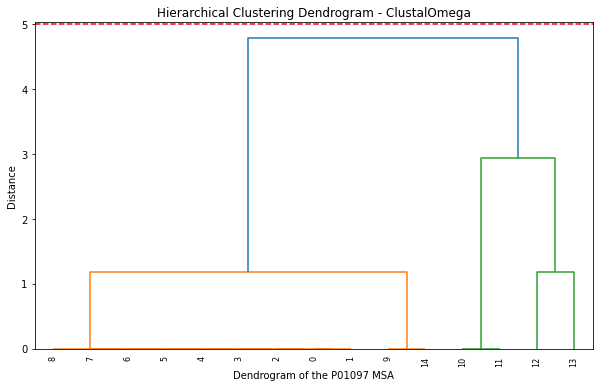

In [11]:
# Plot dendrograms for Clustal_Omega results
plot_dendrograms(clustal_clstr_path, 'ClustalOmega')

## 3. Analysing the quality of prediction

For calculation of the entropy we use a probability distribution with 20 outcomes, where each outcome has an equal probability of 1/20. Entropy is a measure of the uncertainty or randomness associated with a probability distribution. In this case, since the probability distribution is uniform, the entropy is maximized, meaning that there is maximum uncertainty or randomness associated with the outcomes.

With occupancy we define the proportion of non-missing (non-gap) values in the column.

### 3.1. Analysis of occupancy and entropy for MSA (redundant and non-redundant)

Here we will build KDE plots of the occupancy and entropy.

In [15]:
# Load the data with statistics
%store -r blast_stats clustal_stats

In [14]:
# # Plot the statistics distribution for BLAST
# plot_occupancy_entropy_distribution(blast_stats)

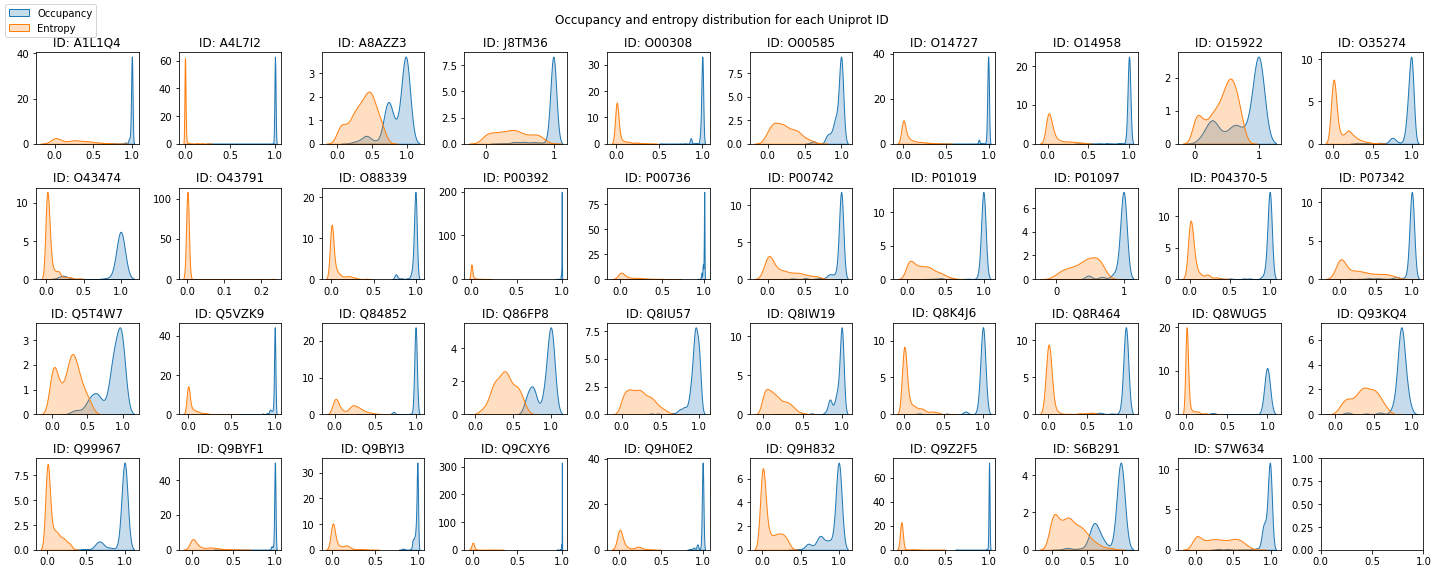

In [14]:
# Plot the statistics distribution for ClustalOmega
plot_occupancy_entropy_distribution(clustal_stats)